In [10]:
import jax, jax.numpy as jnp
# from jaxtyping import Float, Int, Array
from dataclasses import dataclass
from scipy.linalg import expm
from functools import reduce
import math

In [ ]:
I = jnp.eye(2, dtype=complex)
X = jnp.array([[0, 1], [1, 0]], dtype=complex)
Y = jnp.array([[0, -1j], [1j, 0]], dtype=complex)
Z = jnp.array([[1, 0], [0, -1]], dtype=complex)

In [11]:
def exchange_gate_nqubits(n: int, p: float, i: int, j: int):
    if not (0 <= i < n and 0 <= j < n and i != j):
        raise ValueError("Indices i and j must be distinct and in [0 .. n-1].")
    def _kron_all(mats):
        """Kronecker product of a list of matrices."""
        return reduce(jnp.kron, mats)
    def two_qubit_term(pauli):
        mats = [I] * n          # start with identities
        mats[i] = mats[j] = pauli
        return _kron_all(mats)

    XX = two_qubit_term(X)
    YY = two_qubit_term(Y)
    ZZ = two_qubit_term(Z)

    H_swap = (XX + YY + ZZ) / 4.0         # Heisenberg exchange Hamiltonian
    U = expm(-1j * jnp.pi * p * H_swap)   # e^(-i π p H_swap)

    return U


In [53]:
p1 = math.acos(-1/math.sqrt(3)) / math.pi
p2 = math.asin(1/3) / math.pi
gate_specs = [
    ( 1+p1,  [3,4] ),
    # ( p1,    [3,4] ),
    ( p2,    [4,5] ),
    ( 0.5,   [0,3] ),
    ( 1.0,   [3,4] ),
    (-0.5,   [0,3] ),
    (-0.5,   [4,5] ),
    ( 1.0,   [1,0] ),
    (-0.5,   [3,4] ),
    (-0.5,   [0,3] ),
    ( 1.0,   [4,5] ),
    (-0.5,   [1,0] ),
    ( 0.5,   [3,4] ),
    (-0.5,   [0,3] ),
    ( 1.0,   [4,5] ),
    ( 1.0,   [1,0] ),
    (-0.5,   [3,4] ),
    (-0.5,   [0,3] ),
    (-0.5,   [4,5] ),
    ( 1.0,   [3,4] ),
    ( 0.5,   [0,3] ),
    ( 1-p2,  [4,5] ),
    # ( -p1,   [3,4] ),
    ( 1-p1,  [3,4] ),
]

U_circuit = jnp.eye(64, dtype=complex)
for (p, (i, j)) in gate_specs:
    U_gate = exchange_gate_nqubits(6, p, i, j)
    U_circuit = U_gate @ U_circuit

In [16]:
# ---------- Imports & single-qubit operators ---------------------------------
import jax.numpy as jnp
import numpy as np
from functools import reduce
from scipy.linalg import eigh     # Hermitian eigensolver

I = jnp.eye(2, dtype=complex)
X = jnp.array([[0, 1], [1, 0]], dtype=complex)
Y = jnp.array([[0,-1j],[1j, 0]], dtype=complex)
Z = jnp.array([[1, 0], [0,-1]], dtype=complex)

# ---------- Helpers ----------------------------------------------------------
def kron_all(mats):
    """Kronecker product of a list of matrices."""
    return reduce(jnp.kron, mats)

def collective(pauli, n=6):
    """Σ_k (pauli_k)/2  for an n-qubit register."""
    terms = []
    for k in range(n):
        ops = [I]*n
        ops[k] = pauli
        terms.append(kron_all(ops))
    return sum(terms)/2

# ---------- Build Jx, Jy, Jz, J² for 6 qubits --------------------------------
n = 6
Jx = collective(X, n)
Jy = collective(Y, n)
Jz = collective(Z, n)
J2 = Jx@Jx + Jy@Jy + Jz@Jz        # 64×64 Hermitian

# Convert to ordinary NumPy (SciPy needs that)
Jz_np  = np.asarray(Jz)
J2_np  = np.asarray(J2)

# ---------- Computational basis bookkeeping ----------------------------------
basis_bits  = np.arange(2**n)                  # 0 … 63
weights     = np.array([bin(i).count("1") for i in basis_bits])   # Hamming weight

# Build projectors into each Jz (== weight-3) subspace
projectors = {m: np.eye(64)[:, weights==m] for m in range(0, n+1)}

# ---------- For each Hamming-weight block diagonalise J² ---------------------
cols = []          # list of 64 column vectors → will become B
eigmeta = []       # (m, J, local_index) labels for sorting

for m, P in projectors.items():
    #  Restrict J² to this weight subspace
    J2_sub = P.conj().T @ J2_np @ P
    # Diagonalise (Hermitian => real e-vals, orthonormal e-vecs)
    evals, evecs = eigh(J2_sub)
    # evals are J(J+1).  Recover integer J:
    J_vals = np.rint(0.5*(np.sqrt(4*evals + 1)-1)).astype(int)
    
    #  Append each eigenvector to our big list
    for local_idx, (J_val, vec) in enumerate(zip(J_vals, evecs.T)):
        full_vec = P @ vec               # embed back into full 64-dim space
        cols.append(full_vec)
        eigmeta.append((m, J_val, local_idx))

# ---------- Sort columns by (m, J, local_index) ------------------------------
order = np.lexsort(np.array(eigmeta).T[::-1])   # lexsort needs reversed key order
B = np.column_stack([cols[i] for i in order])   # 64×64 unitary

# (Optional) sanity check:   np.allclose(B.conj().T @ B, np.eye(64))

# ---------- Use it -----------------------------------------------------------
U_blocks = B.conj().T @ np.asarray(U_circuit) @ B

# …plot |U_blocks| or manipulate as you like…


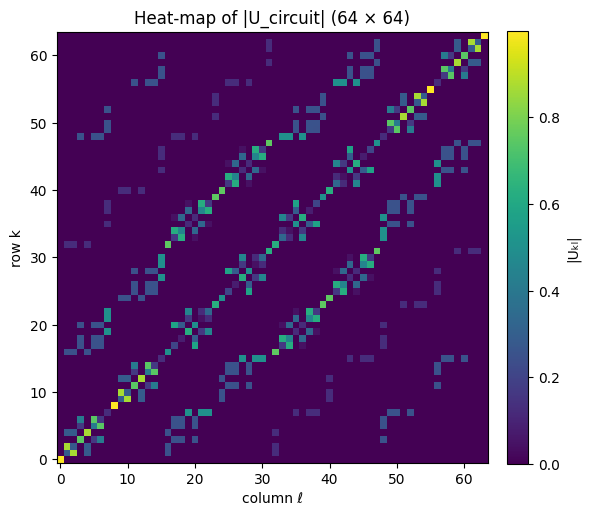

In [59]:
# --- Heat-map of the 64 × 64 unitary ----------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# 1)  Convert the JAX array to a NumPy array that Matplotlib can handle.
U_np = np.asarray(U_circuit)  # 64 × 64 unitary
# U_np = np.asarray(matrix_rearr(U_circuit))  # 64 × 64 unitary

# 2)  Choose what to visualise.  Most people use the magnitude.
data = np.abs(U_np)           # |U|     (use np.real(U_np) or np.angle(U_np) if you prefer)

# 3)  Plot.
plt.figure(figsize=(6, 6))
im = plt.imshow(data, cmap='viridis', origin='lower', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04, label='|Uₖₗ|')
plt.title('Heat-map of |U_circuit| (64 × 64)')
plt.xlabel('column ℓ')
plt.ylabel('row k')
plt.tight_layout()
plt.show()


In [ ]:
# ---- physics constants ----
N_SPINS        = 6                      # three-qubit DFS pair
DIM            = 64                     # 2**N_SPINS
GATE_PAIRS     = [(0,1), (1,2), (3,4), (4,5), (2,3)]  # nearest-neighbour layout
NUM_GATES      = len(GATE_PAIRS)
TARGET_U = jnp.asarray(U_circuit, dtype=jnp.complex64)


In [ ]:
def fidelity(U: jnp.ndarray, U_target: jnp.ndarray) -> jnp.ndarray:
    """Return F = |Tr(U† U_target)|² / d²  (d = 2⁶ = 64)."""
    overlap = jnp.vdot(U_target, U)           # Tr(U_target† U) as scalar
    return (jnp.abs(overlap) ** 2) / (DIM ** 2)


In [ ]:
def obs_from_unitary(U: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([U.real.ravel(), U.imag.ravel()]).astype(jnp.float32)


In [19]:
def state_to_density(psi):
    """
    Given a statevector psi (1D complex array),
    return the density matrix |psi><psi|.
    """
    psi = psi.reshape(-1, 1)  # make it a column vector
    return psi @ psi.conjugate().T  # outer product
def normalize_state(psi):
    """
    Ensure psi is normalized.
    """
    norm = jnp.linalg.norm(psi)
    if norm < 1e-15:
        raise ValueError("Zero norm state.")
    return psi / norm

In [ ]:
logical_0_amps = np.array([0, 0, 1/np.sqrt(2), 0, -1/np.sqrt(2), 0, 0, 0], dtype=complex)
logical_1_amps = np.array([0, -np.sqrt(2/3), -1/np.sqrt(6), 0, -1/np.sqrt(6), 0, 0, 0], dtype=complex)

logical_0_H_amps = (1/jnp.sqrt(2))*(logical_0_amps + logical_1_amps)
logical_1_H_amps = (1/jnp.sqrt(2))*(logical_0_amps - logical_1_amps)

logical_0_amps = normalize_state(logical_0_amps)
logical_1_amps = normalize_state(logical_1_amps)

# Create density matrices
rho_logical_0 = state_to_density(logical_0_amps)
rho_logical_1 = state_to_density(logical_1_amps)

# logical_0_0 = rho_0 \otimes rho_0
rho_00 = jnp.kron(rho_logical_0, rho_logical_0)
rho_01 = jnp.kron(rho_logical_0, rho_logical_1)
rho_10 = jnp.kron(rho_logical_1, rho_logical_0)
rho_11 = jnp.kron(rho_logical_1, rho_logical_1)
# etc. define more as needed.

ip_arr = [rho_logical_0, rho_logical_1]
target_arr = [rho_00, rho_01, rho_10, rho_11]

In [63]:
rows, cols = np.nonzero(rho_11)

# Iterate and print
for r, c in zip(rows, cols):
    print(f"Non-zero element at row {r}, column {c} -> value = {rho_11[r, c]}")


Non-zero element at row 9, column 9 -> value = (0.444444477558136+0j)
Non-zero element at row 9, column 10 -> value = (0.222222238779068+0j)
Non-zero element at row 9, column 12 -> value = (0.222222238779068+0j)
Non-zero element at row 9, column 17 -> value = (0.222222238779068+0j)
Non-zero element at row 9, column 18 -> value = (0.111111119389534+0j)
Non-zero element at row 9, column 20 -> value = (0.111111119389534+0j)
Non-zero element at row 9, column 33 -> value = (0.222222238779068+0j)
Non-zero element at row 9, column 34 -> value = (0.111111119389534+0j)
Non-zero element at row 9, column 36 -> value = (0.111111119389534+0j)
Non-zero element at row 10, column 9 -> value = (0.222222238779068+0j)
Non-zero element at row 10, column 10 -> value = (0.111111119389534+0j)
Non-zero element at row 10, column 12 -> value = (0.111111119389534+0j)
Non-zero element at row 10, column 17 -> value = (0.111111119389534+0j)
Non-zero element at row 10, column 18 -> value = (0.055555559694767+0j)
Non

In [ ]:
def matrix_rearr(M: jnp.ndarray, one_based: bool = False) -> jnp.ndarray:
    special = [9, 10, 12, 17, 18, 20, 33, 34, 36]
    N = M.shape[0]
    if M.shape[1] != N:
        raise ValueError("Matrix must be square.")
    # convert to 0-based if needed
    if one_based:
        idx0 = [i - 1 for i in special]
    else:
        idx0 = list(special)

    # sanity check
    if any(i < 0 or i >= N for i in idx0):
        raise IndexError("One of your special indices is out of range.")

    # build the permutation: specials first, then all the rest in ascending order
    rest = [i for i in range(N) if i not in idx0]
    perm = idx0 + rest

    # now permute rows, then columns
    # (this works on any array-like, no need for np.ix_)
    M_perm = M[perm, :]   # reorder rows
    M_perm = M_perm[:, perm]  # reorder columns
    return M_perm

In [ ]:
for item in target_arr:
    U_np = np.asarray(item)
    # U_np = np.asarray(matrix_rearr(item, one_based=False))
    # 2)  Choose what to visualise.  Most people use the magnitude.
    data = np.abs(U_np)           # |U|     (use np.real(U_np) or np.angle(U_np) if you prefer)

    # 3)  Plot.
    plt.figure(figsize=(6, 6))
    im = plt.imshow(data, cmap='viridis', origin='lower', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04, label='|Uₖₗ|')
    plt.title('Heat-map of |U_circuit| (64 × 64)')
    plt.xlabel('column ℓ')
    plt.ylabel('row k')
    plt.tight_layout()
    plt.show()